# Optogenetic Responsiveness Analysis

Notebook for the bulk analysis of optogenetic responsiveness. Handles the loading and analysis of multiple mice and sessions, as wells as subsessions (e.g., different powers). Will save the analysis for each mouse and each session individually. Also allows for the grouping of mice. 

In [1]:
# Import modules
import os 
import numpy as np
import matplotlib.pyplot as plt
from Lab_Analyses.Utilities.save_load_pickle import load_pickle
from Lab_Analyses.Optogenetics.optogenetic_responses import classify_opto_responses, group_opto_responses
from Lab_Analyses.Optogenetics.load_opto_sessions import load_opto_sessions
from Lab_Analyses.Optogenetics.power_curve import Power_Curve

In [ ]:
# Load Datasets

# Mice
m1 = "JW088"
m2 = "JW095"
m3 = "JW096"
m4 = "JW097"

# Days
d1 = ["220507", "220510"]
d2 = ["220606", "220609"]
d3 = ["220606", "220609"]
d4 = ["220606", "220609"]

# Keyword for which files to load
keywords = ["Soma", "Soma_2"]

# Specify which ROI types you want to include in the analysis
## Put in a list
### None will include all ROI types
ROI_types = ["Soma"]

mice = [m1, m2, m3, m4]
days = [d1, d2, d3, d4]

imaging_datasets, behavior_datasets = load_opto_sessions(mice, days, keywords)

In [ ]:
# Analyze each imaging session/subsession for optogenetic responsiveness
opto_datasets = {}
for (key, image), (_, behavior) in zip(imaging_datasets.items(), behavior_datasets.items()):
    optos = []
    print("-----------------------------------------")
    print(f"Analyzing {key}")
    for i, b in zip(image, behavior):
        opto = classify_opto_responses(
            imaging_data=i, 
            behavior_data=b,
            session_type="pulsed",
            method="test",
            ROI_types=ROI_types,
            window=[-1,1],
            vis_window=[-2,3],
            processed_dFoF=False,
            save=True
        )
        optos.append(opto)
    opto_datasets[key] = optos

## Group the data together

In [4]:
# Group datasets across the different mice and sessions
group_path = r"C:\Users\Jake\Desktop\Analyzed_data\grouped"
experiment_directory = "opto_pulsed"
base_name = "soma_chrimson"
group_save_path = os.path.join(group_path, experiment_directory, base_name)
grouped_datasets = {}
for opto in zip(*opto_datasets.values()):
    group_name = f"{base_name}_{opto[0].session}"
    grouped_data = group_opto_responses(opto, group_name, save=True, save_path=group_save_path)
    grouped_datasets[opto[0].session] = grouped_data

### Visualize the grouped data
Automatically handles saving the figure outputs for each subsession type

In [5]:
# Visualize the data
figure_base_path = r"C:\Users\Jake\Desktop\Figures\grouped_data"
figure_save_path = os.path.join(figure_base_path, experiment_directory, base_name)
parameters = {"title": "default", "hmap_range": (0,3), "cmap": "plasma", "zeroed": True, "sort": True, "center": None}
for name,dataset in grouped_datasets.items():
    if dataset.ROI_types is None:
        rois = "allROIs"
    else:
        if len(ROI_types) > 1:
            sep = "_"
            rois = sep.join(dataset.ROI_types)
        else:
            rois = dataset.ROI_types[0]
    dataset_save_path = os.path.join(figure_save_path, rois, name)
    if not os.path.isdir(dataset_save_path):
        os.makedirs(dataset_save_path)
    dataset.display_results(parameters=parameters, save=True, save_path=dataset_save_path)
    
    # Change if you want all figures to stay visible
    plt.close("all")

## Generate Power curve

One-Way ANOVA results
F statistic:  5.140909017696596 \p-value:  0.00612102142569439


Bonferroni Posttest Results
╒═══════════════╤══════════╤══════════════╤═══════════════════╕
│ comparison    │   t stat │   raw p-vals │   adjusted p-vals │
╞═══════════════╪══════════╪══════════════╪═══════════════════╡
│ 5mw vs. 10mw  │  1.87391 │   0.0616946  │        0.185084   │
├───────────────┼──────────┼──────────────┼───────────────────┤
│ 5mw vs. 15mw  │  3.24383 │   0.00128155 │        0.00384465 │
├───────────────┼──────────┼──────────────┼───────────────────┤
│ 10mw vs. 15mw │  1.34213 │   0.180339   │        0.541016   │
╘═══════════════╧══════════╧══════════════╧═══════════════════╛


Summary Statistics
╒═════════════╤════════════╤═════════════╤═════════════╕
│             │        5mw │        10mw │        15mw │
╞═════════════╪════════════╪═════════════╪═════════════╡
│ mean_diff   │   2.648    │   2.49341   │   2.36885   │
├─────────────┼────────────┼─────────────┼─────────────┤
│ s

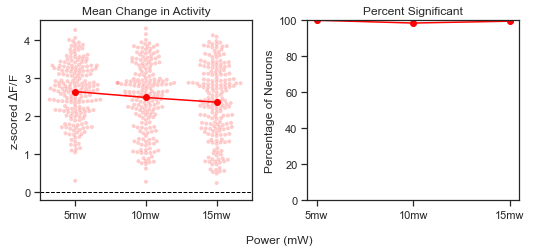

In [6]:
power_save_path = group_save_path
power_curve = Power_Curve(data=grouped_datasets, posttest="Bonferroni", save=True, save_path=power_save_path)